In [2]:
import numpy as np
import pandas as pd 
from scipy.optimize import least_squares
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
sns.set(rc={"figure.figsize":(25, 10)})

In [189]:
dQI = pd.read_csv("DataForImpact/BIGdQI.csv")
dQI['Time'] = dQI['Time'].astype(float)
MI = np.array(dQI['Impact'])
dQ= np.array(dQI['DeltaQ'])
T = np.array(dQI['Time'], dtype=float)

In [190]:
min(dQ)

-31.209121498375225

### Usual OWM: $I_{t+1} = \rho I_t + \lambda Q_{t+1}$

In [185]:
cvlen = 46000
start_point = 1000

def fun1(x, mi: np.array, mi_prev: np.array, dq: np.array):
            return x[0] * mi_prev + x[1] * dq - mi

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun1, np.array([0.1, 0.1]), args=(MI[1:i], MI[:i - 1], dQ[1:i]))
    errors01[i - start_point] = fun1(res_lsq01.x, MI[i], MI[i - 1], dQ[i])


print("MAE: ", np.mean(abs(errors01)))

KeyboardInterrupt: 

In [184]:
cvlen = 46000
learning_window = 100
start_point = 1000

errors02 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq02 = least_squares(fun1, np.array([0.1, 0.1]), args=(MI[i - learning_window:i], MI[i - 1 - learning_window:i - 1], dQ[i - learning_window:i]))
    errors02[i - start_point] = fun1(res_lsq02.x, MI[i], MI[i - 1], dQ[i])

print("MAE: ", np.mean(abs(errors02)))

MAE:  4.087610542790807


### SR model: $I_t = C \sqrt{Q_t}$

In [187]:
cvlen = 46000
start_point = 1000

def fun2(x, mi: np.array, dq: np.array):
            return x[0] * np.sqrt(dq) - mi

errors03 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq11 = least_squares(fun2, np.array([0.1]), args=(MI[1:i], dQ[1:i]))
    errors03[i - start_point] = fun2(res_lsq11.x, MI[i], dQ[i])


print("MAE: ", np.mean(abs(errors03)))

/tmp/ipykernel_6036/1006563109.py:5: RuntimeWarning: invalid value encountered in sqrt
  return x[0] * np.sqrt(dq) - mi


ValueError: Residuals are not finite in the initial point.

In [128]:
cvlen = 46000
learning_window = 100
start_point = 1000

errors04 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq12 = least_squares(fun2, np.array([0.1, 0.1]), args=(MI[i - learning_window:i], dQ[i - learning_window:i]))
    errors04[i - start_point] = fun2(res_lsq12.x, MI[i], dQ[i])

print("MAE: ", np.mean(abs(errors04)))

MAE:  14.221142403939764


### Experimrntal Combo of SRM and OWM: $I_{t+1} = \rho I_t + \lambda \sqrt{Q_{t+1}}$

In [129]:
cvlen = 46000
start_point = 1000

def fun3(x, mi: np.array, mi_prev: np.array, dq: np.array):
            return x[0] * mi_prev + x[1] * np.sqrt(dq) - mi

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun3, np.array([0.1, 0.1]), args=(MI[1:i], MI[:i - 1], dQ[1:i]))
    errors01[i - start_point] = fun3(res_lsq01.x, MI[i], MI[i - 1], dQ[i])


print("MAE: ", np.mean(abs(errors01)))

MAE:  5.272102566367756


In [130]:
cvlen = 46000
learning_window = 100
start_point = 1000

errors02 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq02 = least_squares(fun3, np.array([0.1, 0.1]), args=(MI[i - learning_window:i], MI[i - 1 - learning_window:i - 1], dQ[i - learning_window:i]))
    errors02[i - start_point] = fun3(res_lsq02.x, MI[i], MI[i - 1], dQ[i])

print("MAE: ", np.mean(abs(errors02)))

MAE:  3.6410765341902724


### Experimental model from OWM: $\frac{I_{i+1} - I_i}{\Delta t _{i+1}} = \rho I_i + \lambda \frac{Q_{i+1}}{\Delta t _{i+1}}$

In [117]:
dt = (T[1:] - T[:-1])
dIdt = (MI[1:] - MI[:-1]) / dt
Qdt = dQ[1:] / dt
Ii = MI[:-1]

In [153]:
cvlen = 46000
start_point = 1000

def fun3(x, dIdt: np.array, mi_prev: np.array, Qdt: np.array):
            return x[0] * mi_prev + x[1] * Qdt - dIdt

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun3, np.array([0.1, 0.1]), args=(dIdt[:i], Ii[:i], Qdt[:i]))
    errors01[i - start_point] = Ii[i] * (1 + dt[i] * res_lsq01.x[0]) + res_lsq01.x[1] * Qdt[i] - Ii[i + 1]


print("MAE: ", np.mean(abs(errors01)))

MAE:  19.183232206365943


In [132]:
cvlen = 46000
learning_window = 100
start_point = 1000
def fun3(x, dIdt: np.array, mi_prev: np.array, Qdt: np.array):
            return x[0] * mi_prev + x[1] * Qdt - dIdt

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun3, np.array([0.1, 0.1]), args=(dIdt[i - learning_window:i], Ii[i - learning_window:i], Qdt[i - learning_window:i]))
    errors01[i - start_point] = Ii[i] * (1 + dt[i] * res_lsq01.x[0]) + res_lsq01.x[1] * Qdt[i] - Ii[i + 1]


print("MAE: ", np.mean(abs(errors01)))

MAE:  36.430976846660485


### Experimental model from our intuition: $\frac{y_{i + 1} - y_{i}}{\Delta t_{i+1}} = \rho y_i + \lambda$

In [120]:
y = MI / dQ

In [162]:
cvlen = 46000
start_point = 1000

def fun1(x, y: np.array, y_prev: np.array, dt: np.array):
            return y_prev * (1 + x[0] * dt) + x[1] * dt - y

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun1, np.array([0.1, 0.1]), args=(y[1:i], y[:i - 1], dt[1:i]))
    errors01[i - start_point] = fun1(res_lsq01.x, y[i], y[i - 1], dt[i]) # * dQ[i]


print("MAE: ", np.mean(abs(errors01)))

MAE:  9.547638321678047


(0.0, 100.0)

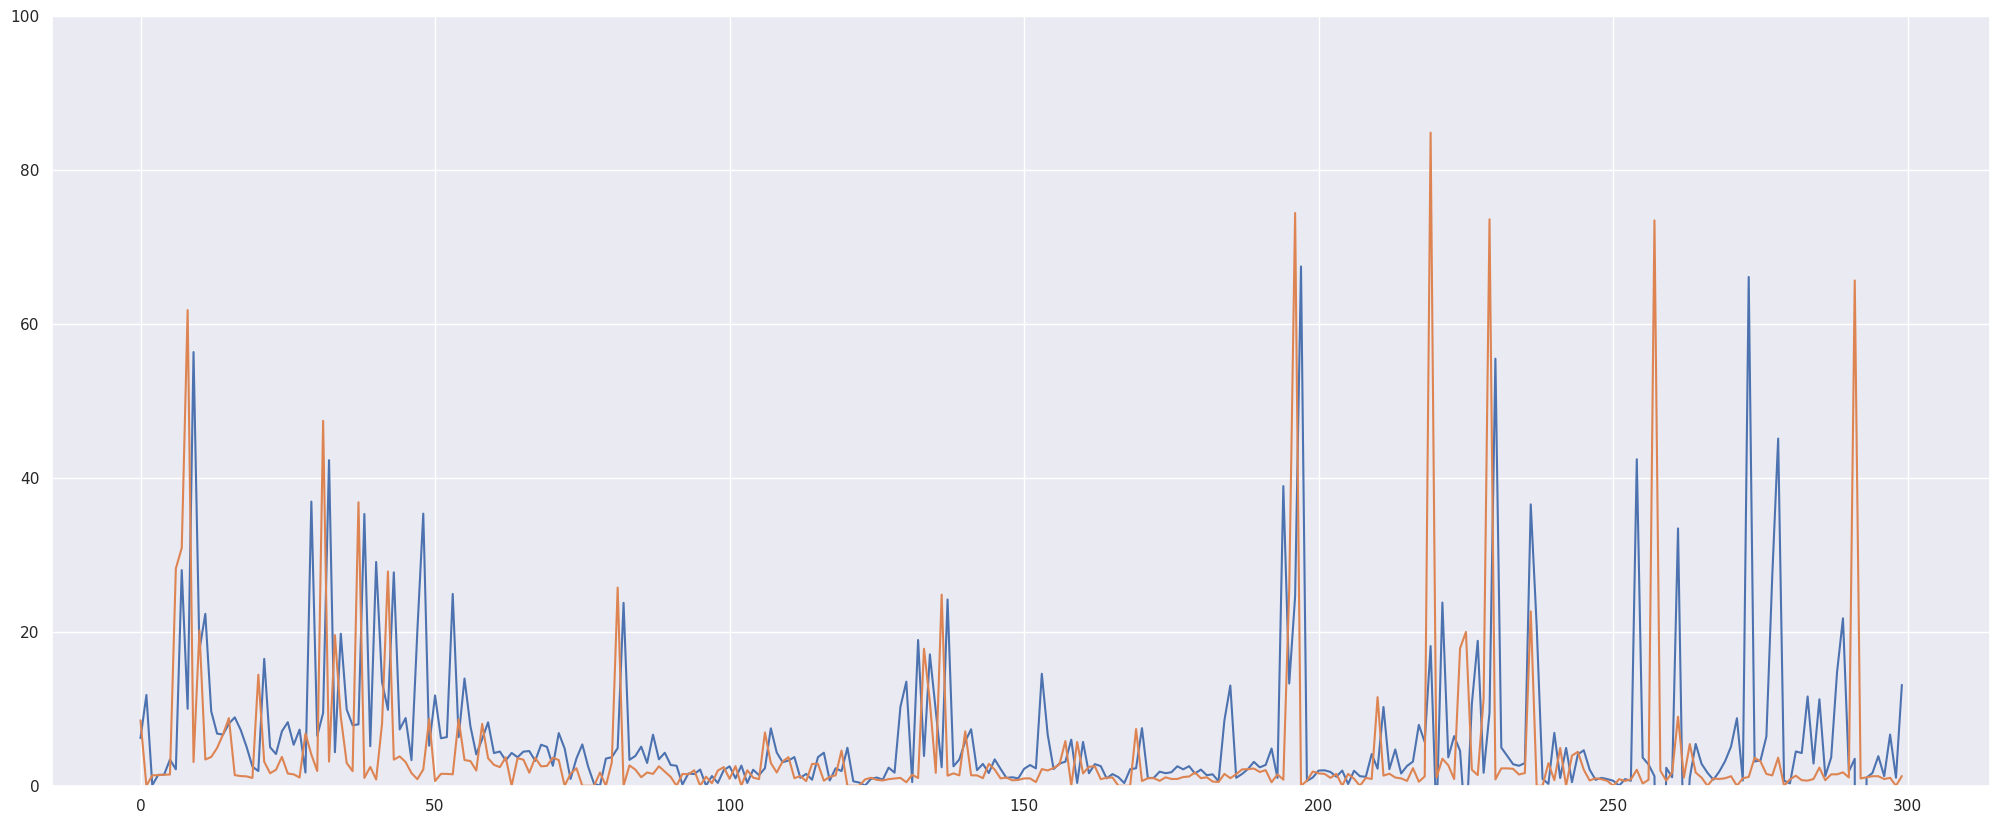

In [163]:
plt.plot(errors01 + MI[100:400] / dQ[100:400])
plt.plot(MI[100:400] / dQ[100:400])
plt.ylim(0, 100)

In [157]:
cvlen = 46000
learning_window = 100
start_point = 1000

def fun1(x, y: np.array, y_prev: np.array, dt: np.array):
            return y_prev * (1 + x[0] * dt) + x[1] * dt - y

errors01 = np.full((cvlen - start_point, ), 0.)

for i in range(start_point, cvlen):
    res_lsq01 = least_squares(fun1, np.array([0.1, 0.1]), args=(y[i - learning_window:i], y[i - 1 - learning_window:i - 1], dt[i - learning_window:i]))
    errors01[i - start_point] = fun1(res_lsq01.x, y[i], y[i - 1], dt[i]) * dQ[i]


print("MAE: ", np.mean(abs(errors01)))

MAE:  20427.010790721386
